In [2]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

Note: you may need to restart the kernel to use updated packages.


In [3]:
import getpass
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()

 ········


In [4]:
pip install -qU langchain-cohere

Note: you may need to restart the kernel to use updated packages.


In [5]:
import getpass
import os

if not os.environ.get("COHERE_API_KEY"):
  os.environ["COHERE_API_KEY"] = getpass.getpass("Enter API key for Cohere: ")

from langchain_cohere import ChatCohere

llm = ChatCohere(model="command-r-plus")

Enter API key for Cohere:  ········


In [6]:
import getpass
import os

if not os.environ.get("COHERE_API_KEY"):
  os.environ["COHERE_API_KEY"] = getpass.getpass("Enter API key for Cohere: ")

from langchain_cohere import CohereEmbeddings

embeddings = CohereEmbeddings(model="embed-english-v3.0")

In [5]:
pip install -qU langchain-pinecone

Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.


In [7]:
os.environ["PINECONE_API_KEY"] = getpass.getpass()

 ········


In [21]:
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone()
index_name = "react-demo"

pc.create_index(
    name=index_name,
    dimension=1024, # Replace with your model dimensions
    metric="cosine", # Replace with your model metric
    spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    ) 
)

index = pc.Index(index_name)

vector_store = PineconeVectorStore(embedding=embeddings, index=index)

In [22]:
os.environ["USER_AGENT"] = "agent"

In [145]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=('https://react.dev/blog/2024/12/05/react-19',),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("page-content", "title")
        )
    ),

)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"]) if "context" in state.keys() else ""
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


In [146]:
from typing import Literal
from langchain.prompts import PromptTemplate
from langgraph.types import Command
import ast

# Create a LangChain prompt template with escaped curly braces
template = """
Analyze the user's question and determine whether it requires updated documentation knowledge. Follow these guidelines:

1. If the question is about a new feature or recent update in React, return: {{"retrieve":"true"}}

2. If the question is related to React basics, foundational concepts, or general usage, return: {{"retrieve":"false"}}

Question: {question}

Your Answer:
"""

react_doc_analysis_prompt = PromptTemplate(
    input_variables=["question"],
    template=template,
)

prompt_analysis_chain = react_doc_analysis_prompt | llm

In [147]:
result = prompt_analysis_chain.invoke({"question":"what are react new features?"}).content

In [148]:
result = ast.literal_eval(result)

In [149]:
print(result)

{'retrieve': 'true'}


In [150]:
def evaluator(state: State) ->Command[Literal['retrieve','generate']]:
    result = prompt_analysis_chain.invoke({"question":state["question"]}).content
    result = ast.literal_eval(result)
    if result['retrieve'] == 'true':
        return Command(
            goto="retrieve"
        )
    return Command(
        goto="generate"
    )


In [151]:
graph_builder = StateGraph(State).add_sequence([retrieve,generate,])
graph_builder.add_node(evaluator)
graph_builder.add_edge(START, "evaluator")
graph = graph_builder.compile()

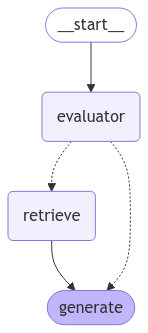

In [152]:
graph

In [153]:
response = graph.invoke({"question": "What are the new updates added to the react new version? answer in 50 words"})
print(response["answer"])

The new React version includes pre-warming for suspended trees, React DOM static APIs, and Custom Element support.


In [155]:
events = graph.stream({
    "question": "What are the new updates added to the react new version? answer in 50 words"
},stream_mode="values")
for event in events:
    print(event)
    

{'question': 'What are the new updates added to the react new version? answer in 50 words'}
{'question': 'What are the new updates added to the react new version? answer in 50 words', 'context': [Document(id='b614b316-aa06-4db9-8433-fee5cb8636a3', metadata={'language': 'en', 'source': 'https://react.dev/blog/2024/12/05/react-19', 'title': 'React v19 – React'}, page_content='React v19 – ReactReactv19Search⌘CtrlKLearnReferenceCommunityBlogBlogReact v19December 05, 2024 by The React Team\n\nNoteReact 19 is now stable! Additions since this post was originally shared with the React 19 RC in April:\nPre-warming for suspended trees: see Improvements to Suspense.\nReact DOM static APIs: see New React DOM Static APIs.\nThe date for this post has been updated to reflect the stable release date.\nReact v19 is now available on npm!\nIn our React 19 Upgrade Guide, we shared step-by-step instructions for upgrading your app to React 19. In this post, we’ll give an overview of the new features in Reac

In [156]:
events = graph.stream({
    "question": "What is react component?"
},stream_mode="values")
for event in events:
    print(event)

{'question': 'What is react component?'}
{'question': 'What is react component?', 'answer': 'A React component is a reusable, self-contained piece of code that forms the building block of a React application. It is a user interface element that can be customized and composed to create complex UIs. Components can be simple, representing UI elements like buttons or input fields, or they can be more complex, encapsulating logic and state to manage specific functionalities within an application.'}


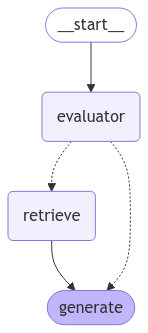

In [115]:
graph

In [35]:
llm.invoke("what is the current react version runnning?").content

'The current major version of React is React 18, which was released on March 29, 2022. This version introduced several new features and improvements, including:\n\n1. Concurrent Features: React 18 brings the ability to start working on concurrent features, which means React can now work on multiple tasks simultaneously, improving the overall performance and responsiveness of your application.\n\n1. Suspense and Streaming Server Rendering: Suspense allows React components to "wait" for something before rendering, enabling better handling of asynchronous operations like data fetching. Streaming Server Rendering improves the user experience by sending the initial HTML to the browser sooner.\n\n1. New APIs: React 18 comes with new APIs like startTransition and useId. startTransition helps you control when updates are applied, enabling better control over the timing of state updates. useId is a new hook that provides a unique ID for accessibility needs.\n\n1. Improved Server Components: Ser